Here I used Carl's IDL code and translated it into Python.
I applied the Python code to the case of 3C286 which was checked by Claire. She also used Carl's IDL code to test.

At the end of this Notebook, I'll compare the results derived by Python code with those from IDL code. The results are consistent.

# 1. Libraries

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import shutil
import itertools
import glob
import numpy as np
import matplotlib.image as mpimg
import pandas as pd

import string
import pickle
import itertools

from tqdm import tqdm
from time import time
from PIL import Image


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [ ]:
from scipy.io import readsav
from astropy.io import fits

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# !pip install latex
# ! apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng

# 2. Connect to Google Drive

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/gfit/
!ls

/content/gdrive/My Drive/Colab Notebooks/gfit
3C286_gfitflex.ipynb	   4C2033_HT03.ipynb  P1055+20_HT03.ipynb
3C333_HT03_gfitflex.ipynb  data		      plots
3C348_HT03_gfitflex.ipynb  libs		      test_3C286.py
3C433_HT03_gfitflex.ipynb  old


In [ ]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/gfit


## 3. Paths to Data Directories

In [ ]:
PROJECT_PATH    = '/content/gdrive/My Drive/Colab Notebooks/gfit'
DATA_PATH       = os.path.join( PROJECT_PATH, 'data' )
PLOT_PATH       = os.path.join( PROJECT_PATH, 'plots' )

HT03_PATH       = os.path.join( DATA_PATH, 'HT03' )
HASLAM_PATH     = os.path.join( DATA_PATH, 'Haslam' )

SPONGE_DATA     = os.path.join( DATA_PATH, 'SPONGE21' )

HT03_HI_SPECTRA = os.path.join( HT03_PATH, 'MS_HI_spectra.npy' )
HT03_FIT_PARAMS = os.path.join( HT03_PATH, 'MS_gfit_params_dict.npy' )
TB_408_SAV      = os.path.join( HASLAM_PATH, 'tb_408.sav' )

HT03_PLOTS      = os.path.join( PLOT_PATH, 'HT03' )

In [ ]:
import libs.gfitflex as fitlib

# 4. Background Temperature from 408MHz (Haslam et al.)

In [ ]:
## Retreive a SINGLE value of 408 t_b from haslam et al. ##
 #
 # params float ell Galactic-longitude
 # params float bee Galactic-latitude
 #
 # return float Tbg_408 Background-Temperature at (l,b)
 #
 # version 08/2016 
 # author Nguyen Van Hiep ##
def get_tb_408(ell,bee,tb_408):
	iell= round(( modangle(ell)/360.)* 1080.)
	ibee= round( (( modangle( bee, 360., negpos=True)+90.)/180.)* 540)

	return tb_408[int(ibee), int(iell)]

## Convert angle to a specified range by finding the angle modulo the extent of the range. ##
 #
 # params 
 # params 
 #
 # return 
 #
 # version 08/2016 
 # author Nguyen Van Hiep ##
def modangle(angle, extent=360., negpos=False):
	offset = 0.
	if(negpos):
		offset = extent/2.

	return ((((angle-offset) % extent) + extent) % extent) - offset



## @galactic_coordinates.pro
## print, 'gl gb', gl, ' ', gb
## tsky=predict_sync(gl,gb, nu=1.4, /interp)+2.725 

inf408 = readsav(TB_408_SAV)
# tbg408 = get_tb_408(gl, gb, inf408.tb_408)
# tsky = 2.725 + txtDat.get_tb_408(ell, bee, inf408.tb_408)*(408./1420.405)**2.8 # Tbg from 408MHz

# 5. Read and plot SPONGE21 data

In [ ]:
# source name
src = '3C286'

## 5.1 Read .sav data

In [ ]:
sav_fname = os.path.join( SPONGE_DATA, '3C286.sav' )
sav_data = readsav(sav_fname)

In [ ]:
sav_data.keys()

dict_keys(['vlsr', 'spec1', 'em_spec', 'sigma', 'emsigma', 'psr1', 'vlsrem', 'cont', 'rms'])

In [ ]:
sav_abs_vlsr = np.squeeze(sav_data['vlsr'])
sav_abs_vlsr.shape

(256,)

In [ ]:
sav_abs_vlsr[:5]

array([38.761154, 38.348957, 37.93676 , 37.524563, 37.11237 ],
      dtype=float32)

In [ ]:
sav_emt = np.squeeze(sav_data['spec1'])
sav_emt.shape

(256,)

In [ ]:
sav_emt[:5]

array([0.9995132, 0.9987244, 0.998914 , 0.9996471, 1.0002834],
      dtype=float32)

In [ ]:
sav_em_vlsr = np.squeeze(sav_data['vlsrem'])
sav_em_vlsr.shape

(2048,)

In [ ]:
sav_em_vlsr[:5]

array([164.73051, 164.56949, 164.40845, 164.24742, 164.0864 ],
      dtype=float32)

In [ ]:
sav_Tb = np.squeeze(sav_data['em_spec'])
sav_Tb.shape

(2048,)

In [ ]:
sav_Tb[:10]

array([-0.9930267 ,  0.27600816, -1.416729  , -0.43233198,  1.3772938 ,
        0.21628399, -0.07442246,  1.937575  , -0.73499936, -1.4035602 ],
      dtype=float32)

In [ ]:
sav_emt_sigma = np.squeeze(sav_data['sigma'])
sav_emt_sigma.shape

(256,)

In [ ]:
sav_emt_sigma[:5]

array([0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
sav_em_sigma = sav_emt_sigma = np.squeeze(sav_data['emsigma'])
sav_em_sigma.shape

(256,)

In [ ]:
sav_em_sigma[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
cont = sav_data['cont']
cont

14.766183

In [ ]:
sav_data['rms']

0.0006967293

In [ ]:
sav_data['psr1']

b'3C286'

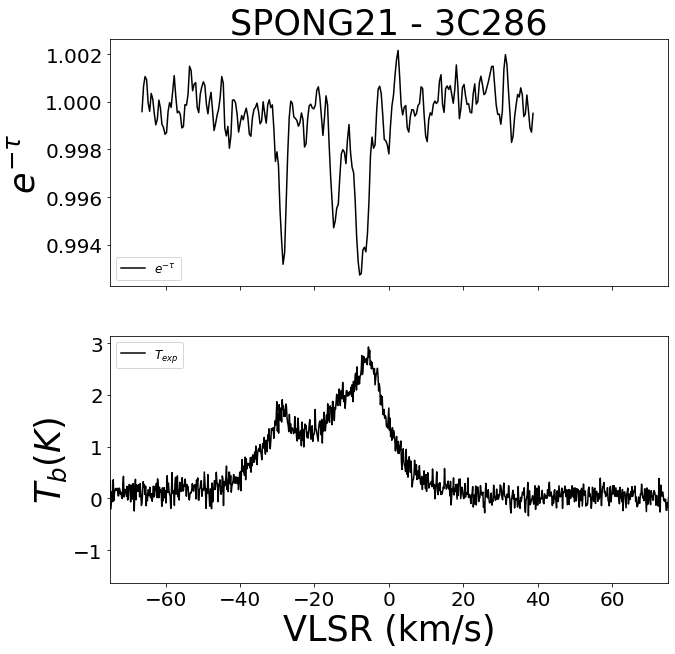

In [ ]:
## Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), sharex=True)

## Absorption
ax1.plot(sav_abs_vlsr, sav_emt, 'k-', label=r'$e^{-\tau}$')
# ax1.fill_between(v_tau, emt-sigemt, emt+sigemt, color='gray', label=r'')

ax1.set_title('SPONG21 - ' + src, fontsize = 35)
ax1.set_ylabel(r'$e^{-\tau}$', fontsize = 35)
# ax1.set_xlabel('VLSR (km/s)', fontsize = 35)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(-75., 75.)
ax1.legend(loc='lower left', fontsize=12)

## Emission
ax2.plot(sav_em_vlsr, sav_Tb, 'k-', label=r'$T_{exp}$')
# ax2.fill_between(v_tb, tb-sigtb, tb+sigtb, color='gray', label=r'')


ax2.set_ylabel('$T_{b} (K)$', fontsize = 35)
ax2.set_xlabel('VLSR (km/s)', fontsize = 35)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(-75., 75.)
ax2.legend(loc='upper left', fontsize=12)

# plt.savefig(src + '.png', bbox_inches='tight', pad_inches=0.09, format='png', dpi=150)

plt.show()
plt.close(fig)

## 5.2 Read On-source spectrum

In [ ]:
abs_datafile = os.path.join( SPONGE_DATA, '3c286_ABS_data.csv' )

In [ ]:
abs_df = pd.read_csv(abs_datafile)
abs_df.head(5)

,id,name,vlsr,emt
0,0,3C286,38.7612,0.999513
1,1,3C286,38.3490,0.998724
2,2,3C286,37.9368,0.998914
3,3,3C286,37.5246,0.999647
4,4,3C286,37.1124,1.000280


In [ ]:
abs_vlsr = abs_df['vlsr'].to_numpy()
emt = abs_df['emt'].to_numpy()

## 5.3 Read off-source spectrum

In [ ]:
em_datafile  = os.path.join( SPONGE_DATA, '3c286_EM_data.csv' )
em_df = pd.read_csv(em_datafile)
em_df.head(5)

,id,name,vlsr,Tb
0,0,3C286,164.731,-0.993027
1,1,3C286,164.569,0.276008
2,2,3C286,164.408,-1.416730
3,3,3C286,164.247,-0.432332
4,4,3C286,164.086,1.377290


In [ ]:
em_vlsr = em_df['vlsr'].to_numpy()
Tb = em_df['Tb'].to_numpy()

# 6. Fitting with Python

## 6.1 Plot spectra for the fit using Python

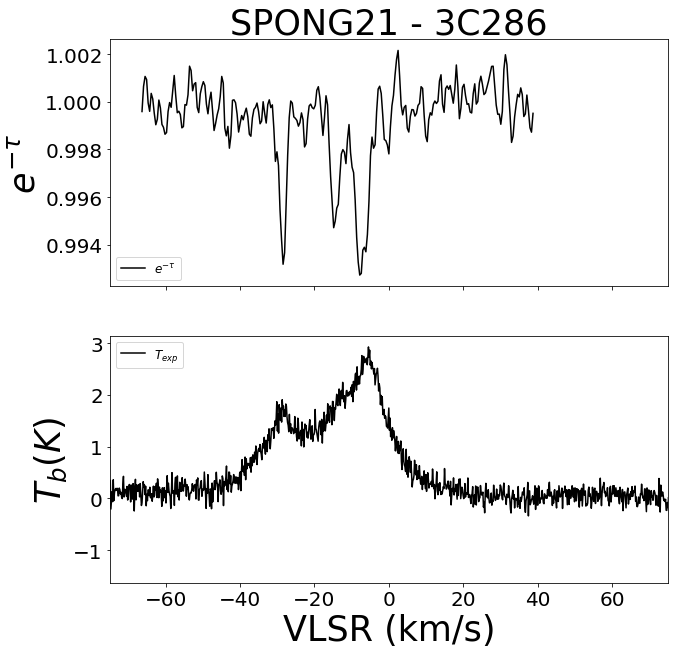

In [ ]:
## Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), sharex=True)

## Absorption
ax1.plot(abs_vlsr, emt, 'k-', label=r'$e^{-\tau}$')
# ax1.fill_between(v_tau, emt-sigemt, emt+sigemt, color='gray', label=r'')

ax1.set_title('SPONG21 - ' + src, fontsize = 35)
ax1.set_ylabel(r'$e^{-\tau}$', fontsize = 35)
# ax1.set_xlabel('VLSR (km/s)', fontsize = 35)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(-75., 75.)
ax1.legend(loc='lower left', fontsize=12)

## Emission
ax2.plot(em_vlsr, Tb, 'k-', label=r'$T_{exp}$')
# ax2.fill_between(v_tb, tb-sigtb, tb+sigtb, color='gray', label=r'')


ax2.set_ylabel('$T_{b} (K)$', fontsize = 35)
ax2.set_xlabel('VLSR (km/s)', fontsize = 35)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(-75., 75.)
ax2.legend(loc='upper left', fontsize=12)

# plt.savefig(src + '.png', bbox_inches='tight', pad_inches=0.09, format='png', dpi=150)

plt.show()
plt.close(fig)

## 6.2 Fitting

In [ ]:
print('Fitting... ' + src)

Fitting... 3C286


### 6.2.1 Fit the opacity profile $e^{-\tau}$

In [ ]:
# Retrieve initial Gaussian guesses for the absorption spectrum
zro0   = 0.0
hgt0   = [0.0065, 0.0066, 0.009]
cen0   = [-28.48, -14.4, -7.3]
wid0   = [2.32,    4.66,   5.0]

hgt0   = [0.005, 0.005, 0.01]
cen0   = [-30., -15., -5.]
wid0   = [2., 4., 5.]

look   = 0

nrg    = len(hgt0)
zro0yn = 0
hgt0yn = [1]*nrg
cen0yn = [1]*nrg
wid0yn = [1]*nrg
corder = 'no'

## WNM
tspin0 = [0.]*nrg
order0 = list(range(nrg))

zro0yn   = 0
tau0yn   = [1]*nrg
cenc0yn  = [1]*nrg
wid0yn   = [1]*nrg
tspin0yn = [0]*nrg



# zrownm = 1.
# hgtwnm = [0.003]
# cenwnm = [-10.4]
# widwnm = [21.46]
# fwnm   = [0.5]

# zrownmyn = 1
# hgtwnmyn = 0
# cenwnmyn = 0
# widwnmyn = 0
# fwnmyn   = 0

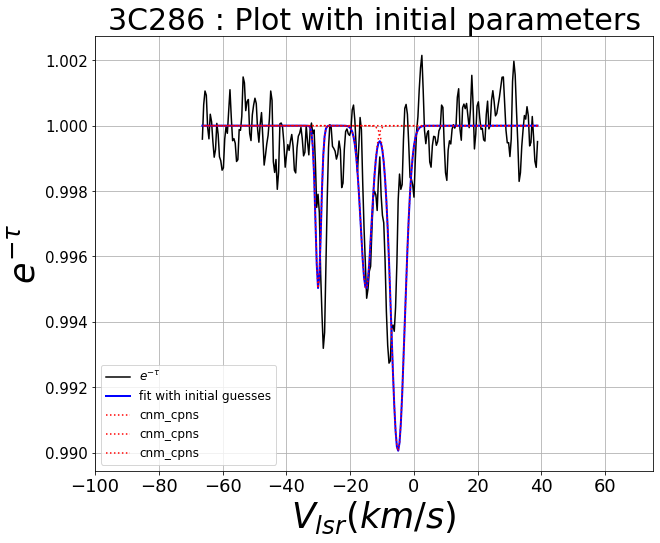

In [ ]:
# Plot with initial parameters
if True:
  plt.figure(figsize=(10,8))
  
  ## Fit these guesses
  tau0  = fitlib.gcurv(abs_vlsr, zro0, hgt0, cen0, wid0)
  tfit0 = np.exp(-tau0)

  # Abs data
  plt.plot(abs_vlsr, emt, 'k-', label=r'$e^{-\tau}$')

  # ABS line - From Guesses
  plt.plot(abs_vlsr, tfit0, 'b-', linewidth=2, label='fit with initial guesses')

  for ccen, chgt, cwid in zip(cen0, hgt0, wid0):
    plt.plot( abs_vlsr, np.exp(-fitlib.gcurv(abs_vlsr, 0., [chgt], [ccen], [cwid]) ), 'r:', label='cnm_cpns')


  plt.title(src + ' : Plot with initial parameters', fontsize=30)
  plt.ylabel(r'$e^{-\tau}$', fontsize=35)
  plt.xlabel('$V_{lsr} (km/s)$', fontsize=35)
  
  # plt.ylim(0.0, 2.0)
  plt.xlim(-100., 75.)

  plt.grid(True)
  plt.tick_params(axis='x', labelsize=18)
  plt.tick_params(axis='y', labelsize=15)
  plt.legend(loc='lower left', fontsize=12)
  plt.show()

In [ ]:
tfita, sigma, resida,\
zro1, hgt1, cen1, wid1,\
sigzro1, sighgt1, sigcen1, sigwid1,\
cov, problem, nparams = fitlib.emt_fit(look, abs_vlsr, emt, [0, len(emt)-1], zro0, hgt0, cen0, wid0, zro0yn, hgt0yn, cen0yn, wid0yn)

print('Absorption line: problem...', problem)

print('1. sigma ', sigma)
print('2. Zro ', zro1)
print('3. tau ', hgt1)
print('\t\t', sighgt1)
print('4. cen ', cen1)
print('\t\t', sigcen1)
print('5. wid ', wid1)
print('\t\t', sigwid1)

Number of bins:  256
Absorption line: problem... 0
1. sigma  0.0007981425472105853
2. Zro  0.0
3. tau  [0.00650557 0.00495597 0.00711914]
		 [0.00047596 0.00041072 0.00035319]
4. cen  [-28.52943777 -14.25491618  -7.33710601]
		 [0.08402695 0.12941237 0.10530978]
5. wid  [2.32006373 3.16156588 4.3117498 ]
		 [0.19769436 0.31077311 0.25563589]


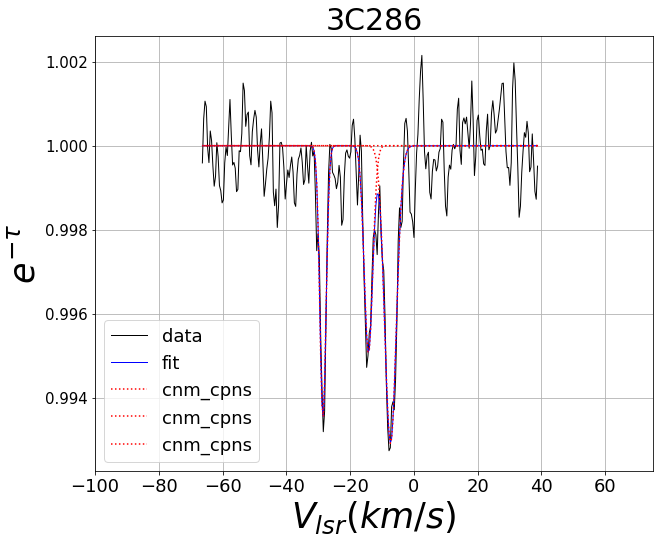

In [ ]:
## Absoprtion line
sum_of_gaussians = fitlib.gcurv(abs_vlsr, zro1, hgt1, cen1, wid1)
emt_fit          = np.exp(-sum_of_gaussians)

plt.figure(figsize=(10,8))
plt.plot(abs_vlsr, emt, 'k-', linewidth=1, label='data')
plt.plot(abs_vlsr, emt_fit, 'b-', linewidth=1, label='fit')

for ccen, chgt, cwid in zip(cen1, hgt1, wid1):
  plt.plot( abs_vlsr, np.exp(-fitlib.gcurv(abs_vlsr, 0., [chgt], [ccen], [cwid]) ), 'r:', label='cnm_cpns')


plt.title(src, fontsize=30)
plt.ylabel(r'$e^{-\tau}$', fontsize=35)
plt.xlabel('$V_{lsr} (km/s)$', fontsize=35)
# plt.xlim(0.0, 2.0)
plt.xlim(-100., 75.)

plt.grid(True)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=15)

# plt.text(0.0, 3.2, r'$f = [0.32\pm0.06]\cdot log_{10}(N^*_{HI}/10^{20}) + [0.81\pm0.05]$, Lee et al.', color='blue', fontsize=20)
plt.legend(loc='lower left', fontsize=18)
plt.show()

### 6.2.2 Fit the $T_\mathrm{exp}$ profile

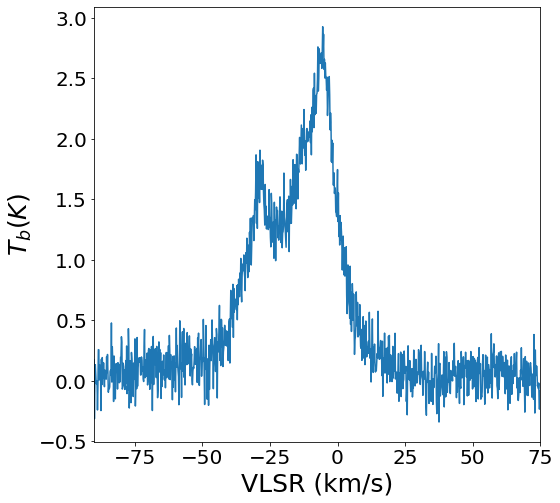

In [ ]:
vmin, vmax = fitlib.get_vrange_id(em_vlsr, -90., 75.)
tb_vlsr    = np.array(em_vlsr[vmin:vmax+1], dtype='float64')
Tb         = np.array(Tb[vmin:vmax+1], dtype='float64')

plt.figure(figsize=(8,8))

plt.plot(tb_vlsr, Tb)

plt.ylabel('$T_{b} (K)$', fontsize = 25)
plt.xlabel('VLSR (km/s)', fontsize = 25)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim(-90., 75.)
plt.show()

In [ ]:
# Initial guesses
zrownm1   = 0.0
hgtwnm1   = [1., 1.]
cenwnm1   = [-5,-20]
widwnm1   = [10,10]
look      = 0
nrgwnm    = len(hgtwnm1)
zrownm1yn = 1
hgtwnm1yn = [1]*nrgwnm
cenwnm1yn = [1]*nrgwnm
widwnm1yn = [1]*nrgwnm
fwnm1     = [0.5]*nrgwnm
fwnm1yn   = [0]*nrgwnm # Don't change here

order1    = [0] if nrg==1 else list(range(nrg))
tspin1    = [30.]*nrg
tspin1yn  = [1]*nrg

zrocnm1   = 0.
hgtcnm1   = hgt1
cencnm1   = cen1
widcnm1   = wid1
zrocnm1yn = 0
hgtcnm1yn = [0]*nrg
cencnm1yn = [0]*nrg
widcnm1yn = [0]*nrg

look      = -1
xindxrange= [0, len(tb_vlsr)-1]

## ---Parameters within tbgfitflex_exp.pro, sets number of loops (nloopmax)
## ---and the fractional change in each parameter per loop iteration
nloopmax     = 100
halfasseduse = 0.2

## @galactic_coordinates.pro
## print, 'gl gb', gl, ' ', gb
## tsky=predict_sync(gl,gb, nu=1.4, /interp)+2.725 
tsky  = 2.8 ## 3.41
tdata = Tb + tsky

In [ ]:
simple = False
if simple:
	tfite, sigma, reside,\
	zrocnm1, hgtcnm1, cencnm1, widcnm1, tspincnm1, \
	sigzrocnm1, sighgtcnm1, sigcencnm1, sigwidcnm1, sigtspincnm1, \
	zrownm1, hgtwnm1, cenwnm1, widwnm1, fwnm1, \
	sigzrownm1, sighgtwnm1, sigcenwnm1, sigwidwnm1, sigfwnm1, \
	cov, problem, nloop, \
	tb_cont, tb_wnm_tot, tb_cnm_tot, \
	exp_tau_sum, nloopmax, halfasseduse = fit.efit(look, tb_vlsr, tdata, xindxrange, \
				zrocnm1, hgtcnm1, cencnm1, widcnm1, tspin1, order1, \
				zrocnm1yn, hgtcnm1yn, cencnm1yn, widcnm1yn, tspin1yn, \
				cont, hgtwnm1, cenwnm1, widwnm1, fwnm1, \
				1, hgtwnm1yn, cenwnm1yn, widwnm1yn, fwnm1yn, nloopmax=nloopmax, halfasseduse=0.2)

	tb_tot_fit = tb_cnm_tot+tb_wnm_tot+tb_cont-tsky
	tb_tot_fit = tfite-tsky
	tdata      = tdata-tsky

else:
  print( 'Not Simple!!')
  nrgcnm = nrg
  if ( (nrgcnm == 0) or (nrgcnm == 1) ):
    orders = [[0]]
  else:
    ## Orders of (peaks) components
    orders = list(itertools.permutations(range(nrgcnm)))
    orders = [list(x) for x in orders]
  ## Endif for orders

  n_loops    = np.math.factorial(nrgcnm)
  f_pom      = np.zeros( (3**nrgwnm, nrgwnm), dtype='float64')             #fltarr(nrgwnm,3^nrgwnm)
  sigmas     = np.zeros( 3**nrgwnm*n_loops, dtype='float64')               #fltarr(3^nrgwnm*factorial(nrgcnm))
  Tspins     = np.zeros( (3**nrgwnm*n_loops, nrgcnm), dtype='float64')     ## fltarr(nrgcnm, 3^nrgwnm*factorial(nrgcnm))
  Tspins_err = np.zeros( (3**nrgwnm*n_loops, nrgcnm), dtype='float64')     ## fltarr(nrgcnm, 3^nrgwnm*factorial(nrgcnm))

  Fs         = np.zeros( (3**nrgwnm*n_loops, nrgwnm) ) ## fltarr(ncnm, 3^nwnm*factorial(ncnm))
  sigFs      = np.zeros( (3**nrgwnm*n_loops, nrgwnm) ) ## fltarr(ncnm, 3^nwnm*factorial(ncnm))

  # sigmatemp  = np.zeros( n_loops, dtype='float64')                         ## fltarr(factorial(nrgcnm))
  orders_all = np.zeros( (3**nrgwnm*n_loops, nrgcnm), dtype='float64')     ## fltarr(nrgcnm,3^nrgwnm*factorial(nrgcnm))
  fwnm_all   = np.zeros( (3**nrgwnm*n_loops, nrgwnm) )

  for k in range(nrgwnm):
    f_pom[:,k] = np.mod( np.arange(3**nrgwnm)/3**k, 3 )

  # f_pom = f_pom*0.5
  f_pom = np.floor(f_pom)*0.5

  # if nrgwnm = 2 ->
  # [[0.  0. ]
  #  [0.5 0. ]
  #  [1.  0. ]
  #  [0.  0.5]
  #  [0.5 0.5]
  #  [1.  0.5]
  #  [0.  1. ]
  #  [0.5 1. ]
  #  [1.  1. ]]

  for j in range(3**nrgwnm):
    fwnm1 = f_pom[j,:]
    print( '\n ************* \n Starting orders loop: ', j)
    print( str(100.*round( float(j)/float(3**nrgwnm),2 ) ) + '%')

    for oval in range(n_loops):
      order1 = orders[oval]

      look = -1

      tfita, sigmaw, reside,\
      zrocnm2, hgtcnm2, cencnm2, widcnm2, tspin2, \
      sigzrocnm2, sighgtcnm2, sigcencnm2, sigwidcnm2, sigtspin2, \
      zrownm2, hgtwnm2, cenwnm2, widwnm2, fwnm2, \
      sigzrownm2, sighgtwnm2, sigcenwnm2, sigwidwnm2, sigfwnm2, \
      cov, problem, nloop, \
      tb_cont, tb_wnm_tot, tb_cnm_tot, \
      exp_tau_sum, nloopmax, halfasseduse = fitlib.texp_fit(look, tb_vlsr, tdata, xindxrange, \
            zrocnm1, hgtcnm1, cencnm1, widcnm1, tspin1, order1, \
            zrocnm1yn, hgtcnm1yn, cencnm1yn, widcnm1yn, tspin1yn, \
            cont, hgtwnm1, cenwnm1, widwnm1, fwnm1, \
            1, hgtwnm1yn, cenwnm1yn, widwnm1yn, fwnm1yn, nloopmax=nloopmax, halfasseduse=0.2)

      print( '>>>> Results: <<<<<<')
      print( 'fwnm is: ', f_pom[j, :])
      print( 'order1 is:', order1)
      print( 'Tspin is: ', tspin2)
      print( '   - sigTsin:', sigtspin2)

      sigmas[j*n_loops+oval]        = sigmaw
      Tspins[j*n_loops+oval, :]     = tspin2
      Tspins_err[j*n_loops+oval, :] = sigtspin2

      orders_all[j*n_loops+oval, :] = order1
      fwnm_all[j*n_loops+oval, :]   = fwnm1

      Fs[j*n_loops+oval, :]         = fwnm2
      sigFs[j*n_loops+oval, :]      = sigfwnm2
		## Endfor oval
	## Endfor j

  tspin_final      = np.zeros( nrgcnm, dtype='float64')
  tspin_err_final  = np.zeros( nrgcnm, dtype='float64')
  F                = (n_loops)*(3**nrgwnm)
  w                = (1.0/sigmas)**2
  for j in range(nrgcnm):
    # w         = (1.0/sigmas)**2

    tspin_val = np.sum(w*Tspins[:,j])/np.sum(w)

    tspin_err = ( np.sum( w*((Tspins[:,j]-tspin_val)**2+Tspins_err[:,j]**2) )/np.sum(w) )*(F/(F-1.))
    tspin_err = np.sqrt(tspin_err)

    tspin_final[j]     = tspin_val
    tspin_err_final[j] = tspin_err
	## Endfor

  print( '---------------------------')
  print( 'Final:')
  for jj in range(nrgcnm):
    print( 'Tspin is: ', tspin_final[jj], '+/-', tspin_err_final[jj])
  ## Endfor jj

  ## Fwnms
  fs_final    = np.zeros( nrgwnm )
  sigfs_final = np.zeros( nrgwnm )
  for j in range(nrgwnm):
    fs_val = np.sum(w*Fs[:,j])/np.sum(w)
    sigfs  = ( np.sum( w*((Fs[:,j]-fs_val)**2 + sigFs[:,j]**2) )/np.sum(w) )*(F/(F-1.))
    sigfs  = np.sqrt(sigfs/ float(n_loops) )

    fs_final[j]    = fs_val
    sigfs_final[j] = sigfs
  # End - for

  for jj in range(nrgwnm):
    print( 'F(k) is: ', fs_final[jj], '+/-', sigfs_final[jj])

  m = np.argmin(sigmas)
  print( 'where sigmas is min:', m, sigmas[m])

  fwnm1   = f_pom[ int( np.floor( float(m)/n_loops ) ), :]
  order1  = orders[ int(np.mod(float(m), n_loops ) )]
  fwnm1yn = [0]*nrgwnm # do not change

  print( 'fwnm: ', fwnm1)
  print( 'order1: ', order1)



  ## Do the last fit
  look = -1

  tfita, sigmaw, reside,\
  zrocnm2, hgtcnm2, cencnm2, widcnm2, tspin2, \
  sigzrocnm2, sighgtcnm2, sigcencnm2, sigwidcnm2, sigtspin2, \
  zrownm2, hgtwnm2, cenwnm2, widwnm2, fwnm2, \
  sigzrownm2, sighgtwnm2, sigcenwnm2, sigwidwnm2, sigfwnm2, \
  cov, problem, nloop, \
  tb_cont, tb_wnm_tot, tb_cnm_tot, \
  exp_tau_sum, nloopmax, halfasseduse = fitlib.texp_fit(look, tb_vlsr, tdata, xindxrange, \
        zrocnm1, hgtcnm1, cencnm1, widcnm1, tspin1, order1, \
        zrocnm1yn, hgtcnm1yn, cencnm1yn, widcnm1yn, tspin1yn, \
        cont, hgtwnm1, cenwnm1, widwnm1, fwnm1, \
        1, hgtwnm1yn, cenwnm1yn, widwnm1yn, fwnm1yn, nloopmax=nloopmax, halfasseduse=0.2)

  tb_tot_fit = tfita-tsky
  tdata      = tdata-tsky
## End else

Not Simple!!

 ************* 
 Starting orders loop:  0
0.0%
>>>> Results: <<<<<<
fwnm is:  [0. 0.]
order1 is: [0, 1, 2]
Tspin is:  [111.70499449  64.23186561   1.11432015]
   - sigTsin: [ 7.79253039 10.58311752 12.75187097]
>>>> Results: <<<<<<
fwnm is:  [0. 0.]
order1 is: [0, 2, 1]
Tspin is:  [111.70494123  64.23011944   1.11430958]
   - sigTsin: [ 7.79254335 10.58309309 12.75226992]
>>>> Results: <<<<<<
fwnm is:  [0. 0.]
order1 is: [1, 0, 2]
Tspin is:  [111.70499449  64.23186561   1.11432015]
   - sigTsin: [ 7.79253039 10.58311752 12.75187097]
>>>> Results: <<<<<<
fwnm is:  [0. 0.]
order1 is: [1, 2, 0]
Tspin is:  [111.70499449  64.23186561   1.11432015]
   - sigTsin: [ 7.79253039 10.58311752 12.75187097]
>>>> Results: <<<<<<
fwnm is:  [0. 0.]
order1 is: [2, 0, 1]
Tspin is:  [111.70494123  64.23011944   1.11430958]
   - sigTsin: [ 7.79254335 10.58309309 12.75226992]
>>>> Results: <<<<<<
fwnm is:  [0. 0.]
order1 is: [2, 1, 0]
Tspin is:  [111.70494124  64.23011937   1.11430958]
   - si

In [ ]:
print( 'Expected Emission profile: problem...', problem)
print( 'Nloop:', nloop)
print( 'xindxrange:', xindxrange)

print( 'Length of VLSR indices (xindxrange): ', len(xindxrange))
print( 'Length of Tb data: ', len(tdata))
print( 'Length of Tb_tot_fit: ', len(tb_tot_fit))

Expected Emission profile: problem... -2
Nloop: 99
xindxrange: [0, 1025]
Length of VLSR indices (xindxrange):  2
Length of Tb data:  1026
Length of Tb_tot_fit:  1026


In [ ]:
print('')
print('CNM:')
print( '1. sigma: ', np.round(sigmaw, 3))
print( '2. Zro: ', np.round(zro1, 3))
print( '3. tau: ', np.round(hgt1, 4))
print( '\t sigtau: ', np.round(sighgt1, 4))
print( '4. cen: ', np.round(cen1, 3))
print( '\t sigcen: ', np.round(sigcen1, 3))
print( '5. wid: ', np.round(wid1, 3))
print( '\t sigwid:', np.round(sigwid1, 3))
print( '6. Tspin: ', np.round(tspin2, 3))
print( '\t sig_Tspin: ', np.round(sigtspin2, 3))

print()
print('WNM:')
print( '7. hgt-WNM: ', np.round(hgtwnm2, 3))
print( '\t sighgt: ', np.round(sighgtwnm2, 3))
print( '8. V0-WNM: ', np.round(cenwnm2, 3))
print( '\t sigcen: ', np.round(sigcenwnm2, 3))
print( '9. Width-WNM: ', np.round(widwnm2, 3))
print( '\t sigwid: ', np.round(sigwidwnm2, 3))
print( '10. fwnm1-WNM: ', np.round(fwnm2, 3))
print( '\t sig_fwnm: ', np.round(sigfwnm2, 3))
print( '11. fwnm final: ', np.round(fs_final, 3))
print( '\t sig_fwnm final: ', np.round(sigfs_final, 3))


CNM:
1. sigma:  0.152
2. Zro:  0.0
3. tau:  [0.0065 0.005  0.0071]
	 sigtau:  [0.0005 0.0004 0.0004]
4. cen:  [-28.529 -14.255  -7.337]
	 sigcen:  [0.084 0.129 0.105]
5. wid:  [2.32  3.162 4.312]
	 sigwid: [0.198 0.311 0.256]
6. Tspin:  [111.705  64.232   1.114]
	 sig_Tspin:  [ 7.793 10.583 12.752]

WNM:
7. hgt-WNM:  [1.624 1.362]
	 sighgt:  [0.064 0.023]
8. V0-WNM:  [ -5.533 -17.887]
	 sigcen:  [0.138 0.323]
9. Width-WNM:  [ 9.934 36.763]
	 sigwid:  [0.307 0.586]
10. fwnm1-WNM:  [0. 0.]
	 sig_fwnm:  [0. 0.]
11. fwnm final:  [0.5 0.5]
	 sig_fwnm final:  [0.168 0.168]


In [ ]:
print('tb_cont: ', tb_cont[:5])

tb_cont:  [2.85264882 2.85264882 2.85264882 2.85264882 2.85264882]


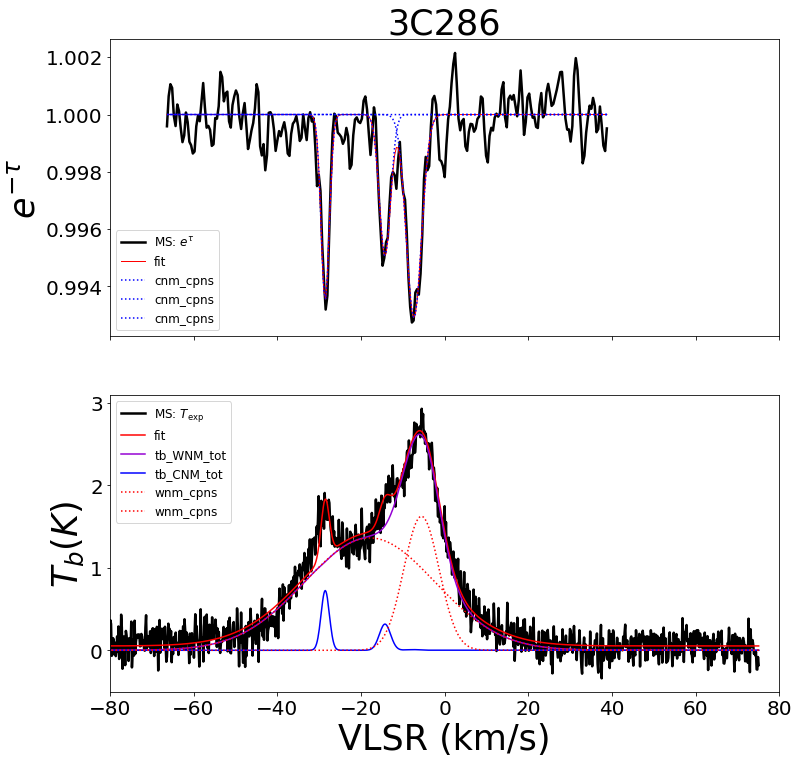

In [ ]:
# Plot spectra
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,12))

ax1.plot(abs_vlsr, emt, 'k-', linewidth=2.5, label=r'MS: $e^{\tau}$')
ax1.plot(abs_vlsr, emt_fit, 'r-', linewidth=1, label='fit')

for ccen, chgt, cwid in zip(cen1, hgt1, wid1):
  ax1.plot( abs_vlsr, np.exp(-fitlib.gcurv(abs_vlsr, 0., [chgt], [ccen], [cwid]) ), 'b:', label='cnm_cpns')

ax1.set_title(src, fontsize = 35)
ax1.set_ylabel(r'$e^{-{\tau}}$', fontsize = 35)
# ax1.set_xlabel('VLSR (km/s)', fontsize = 35)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(-80., 80.)
ax1.legend(loc='lower left', fontsize=12)





## EM spec
ax2.plot(tb_vlsr, tdata, 'k-', lw=2.5, label=r'MS: $T_\mathrm{exp}$')

ax2.plot(tb_vlsr, tb_tot_fit, 'r-', label='fit')
ax2.plot(tb_vlsr, tb_wnm_tot, color='darkviolet', ls='-', label='tb_WNM_tot')
ax2.plot(tb_vlsr, tb_cnm_tot, 'b-', label='tb_CNM_tot')

for wcen, whgt, wwid in zip(cenwnm2, hgtwnm2, widwnm2):
  ax2.plot( tb_vlsr, fitlib.gcurv(tb_vlsr, 0., [whgt], [wcen], [wwid]), 'r:', label='wnm_cpns')

# ax2.set_title(sc, fontsize = 35)
ax2.set_ylabel('$T_{b} (K)$', fontsize = 35)
ax2.set_xlabel('VLSR (km/s)', fontsize = 35)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

ax2.set_xlim(-80., 80.)

plt.legend(loc='upper left', fontsize=12)

# Save the plot
plt.savefig( os.path.join(HT03_PLOTS, src + '_python.png'), bbox_inches='tight', pad_inches=0.09, format='png', dpi=150)

plt.show()
plt.close(fig)
print()

In [ ]:
# Summary
print('Source: ', src)

print('')
print('CNM:')
print( '1. sigma: ', np.round(sigmaw, 3))
print( '2. Zro: ', np.round(zro1, 3))
print( '3. tau: ', np.round(hgt1, 4))
print( '\t sigtau: ', np.round(sighgt1, 4))
print( '4. cen: ', np.round(cen1, 3))
print( '\t sigcen: ', np.round(sigcen1, 3))
print( '5. wid: ', np.round(wid1, 3))
print( '\t sigwid:', np.round(sigwid1, 3))
print( '6. Tspin: ', np.round(tspin2, 3))
print( '\t sig_Tspin: ', np.round(sigtspin2, 3))

print()
print('WNM:')
print( '7. hgt-WNM: ', np.round(hgtwnm2, 3))
print( '\t sighgt: ', np.round(sighgtwnm2, 3))
print( '8. V0-WNM: ', np.round(cenwnm2, 3))
print( '\t sigcen: ', np.round(sigcenwnm2, 3))
print( '9. Width-WNM: ', np.round(widwnm2, 3))
print( '\t sigwid: ', np.round(sigwidwnm2, 3))
# print( '10. fwnm1-WNM: ', np.round(fwnm2, 3))
# print( '\t sig_fwnm: ', np.round(sigfwnm2, 3))
print( '10. fwnm final: ', np.round(fs_final, 3))
print( '\t sig_fwnm final: ', np.round(sigfs_final, 3))

print()
print()

## Calculating column densities ##
NH_cnm       = 1.064467 * 0.0183 * 1. * hgt1 * wid1 * tspin2
pom          = sighgt1**2*(0.0194797*wid1*tspin2)**2 + sigwid1**2*(0.0194797*hgt1*tspin2)**2 + sigtspin2*(0.0194797*hgt1*wid1)**2
delta_NH_cnm = np.sqrt(pom)
print( 'NH_cnm: ', np.round(NH_cnm,3), '+/-', np.round(delta_NH_cnm,3) )

NH_wnm       = 1.064467 * 0.0183 * 1. * hgtwnm2 * widwnm2
pomw         = NH_wnm**2*( (sighgtwnm2/hgtwnm2)**2 + (sigwidwnm2/widwnm2)**2 )
delta_NH_wnm = np.sqrt(pomw)
print( 'NH_wnm: ', np.round(NH_wnm,3), '+/-', np.round(delta_NH_wnm,3) )

## solving for Tkmax
Tkmax    = 21.855*wid1**2
sigTkmax = (sigwid1/wid1)*2*Tkmax

Tkmaxw    = 21.855*(widwnm2)**2
sigTkmaxw = (sigwidwnm2/widwnm2)*2*Tkmaxw

print( 'Sigma for the fit: ', round(sigmaw,4))
print()

print( '>Tkmax (WNM):', np.round(Tkmaxw, 3))
print( '>>> sigTkmax (WNM): ', np.round(sigTkmaxw, 3))
print()
print( '>Tkmax (CNM):', np.round(Tkmax, 3))
print( '>>> sigTkmax (CNM): ', np.round(sigTkmax, 3))
print()
print( '>Tspin[K]: ', np.round(tspin2, 3))
print( '>>sigTspin[K]: ', np.round(sigtspin2, 3))

Source:  3C286

CNM:
1. sigma:  0.152
2. Zro:  0.0
3. tau:  [0.0065 0.005  0.0071]
	 sigtau:  [0.0005 0.0004 0.0004]
4. cen:  [-28.529 -14.255  -7.337]
	 sigcen:  [0.084 0.129 0.105]
5. wid:  [2.32  3.162 4.312]
	 sigwid: [0.198 0.311 0.256]
6. Tspin:  [111.705  64.232   1.114]
	 sig_Tspin:  [ 7.793 10.583 12.752]

WNM:
7. hgt-WNM:  [1.624 1.362]
	 sighgt:  [0.064 0.023]
8. V0-WNM:  [ -5.533 -17.887]
	 sigcen:  [0.138 0.323]
9. Width-WNM:  [ 9.934 36.763]
	 sigwid:  [0.307 0.586]
10. fwnm final:  [0.5 0.5]
	 sig_fwnm final:  [0.168 0.168]


NH_cnm:  [0.033 0.02  0.001] +/- [0.004 0.003 0.002]
NH_wnm:  [0.314 0.976] +/- [0.016 0.023]
Sigma for the fit:  0.1521

>Tkmax (WNM): [ 2156.624 29537.512]
>>> sigTkmax (WNM):  [133.264 942.428]

>Tkmax (CNM): [117.639 218.452 406.31 ]
>>> sigTkmax (CNM):  [20.048 42.946 48.179]

>Tspin[K]:  [111.705  64.232   1.114]
>>sigTspin[K]:  [ 7.793 10.583 12.752]


# 7. Compare with the results from IDL code (from Claire, she used Carl's IDL code for 3C286)

Below are the results from Claire's fitting using IDL code

In [ ]:
sav_EM_params_file = os.path.join( SPONGE_DATA, '3C286_EM_params.sav' )
sav_EM_params = readsav(sav_EM_params_file)

In [ ]:
sav_EM_params.keys()

dict_keys(['xdataem', 'tdata', 'tb_tot_fit', 'tb_cnm_tot', 'tb_wnm_tot', 'hgtwnm2', 'sighgtwnm2', 'cenwnm2', 'sigcenwnm2', 'widwnm2', 'sigwidwnm2', 'zrownm2', 'sigmaw', 'tkmaxw', 'nh_wnm', 'delta_nh_wnm', 'fwnm2', 'cov', 'name'])

In [ ]:
print('hgtwnm2: ', sav_EM_params['hgtwnm2'])
print('cenwnm2: ', sav_EM_params['cenwnm2'])
print('widwnm2: ', sav_EM_params['widwnm2'])

hgtwnm2:  [1.62791883 1.36898476]
cenwnm2:  [ -5.57016268 -17.80554191]
widwnm2:  [ 9.89116387 37.11672708]


In [ ]:
sav_ABS_params_file = os.path.join( SPONGE_DATA, '3C286_ABS_params.sav' )
sav_ABS_params = readsav(sav_ABS_params_file)

In [ ]:
sav_ABS_params.keys()

dict_keys(['xdata', 'taudata', 'tfit', 'hgt1', 'sighgt1', 'cen1', 'sigcen1', 'wid1', 'sigwid1', 'zro1', 'sigma', 'tkmax', 'tspin2', 'sigtspin2', 'nh_cnm', 'delta_nh_cnm', 'name', 'order1', 'tsky'])

In [ ]:
print('hgt1: ', sav_ABS_params['hgt1'])
print('cen1: ', sav_ABS_params['cen1'])
print('wid1: ', sav_ABS_params['wid1'])

hgt1:  [0.00662102 0.00572642 0.00721011]
cen1:  [-28.548777 -14.283163  -7.335736]
wid1:  [2.3874547 3.0825617 4.333463 ]


In [ ]:
print('tspin2: ', sav_ABS_params['tspin2'])
print('sigtspin2: ', sav_ABS_params['sigtspin2'])

tspin2:  [109.59914233  56.12216239   1.08456218]
sigtspin2:  [ 9.16118653 11.09681985 15.40869702]


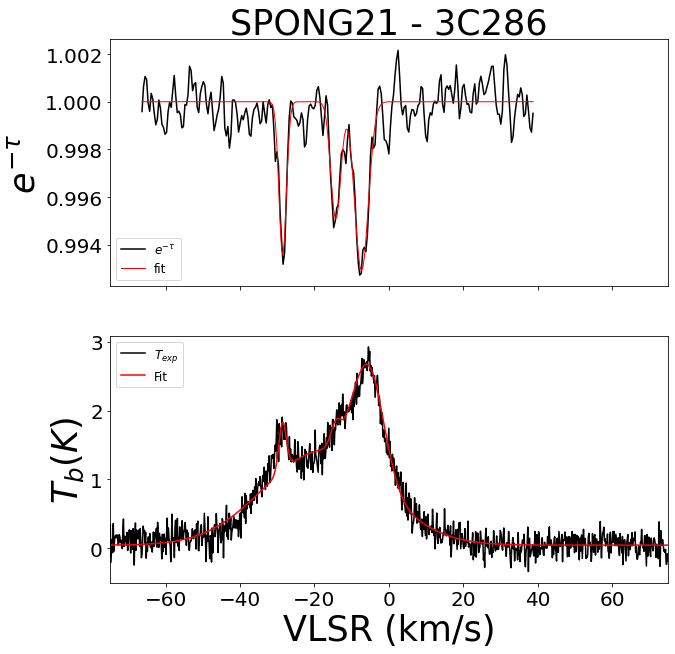

In [ ]:
## Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), sharex=True)

## Absorption
ax1.plot(abs_vlsr, emt, 'k-', label=r'$e^{-\tau}$')
ax1.plot(abs_vlsr, emt_fit, 'r-', linewidth=1, label='fit')
# ax1.fill_between(v_tau, emt-sigemt, emt+sigemt, color='gray', label=r'')

ax1.set_title('SPONG21 - ' + src, fontsize = 35)
ax1.set_ylabel(r'$e^{-\tau}$', fontsize = 35)
# ax1.set_xlabel('VLSR (km/s)', fontsize = 35)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(-75., 75.)
ax1.legend(loc='lower left', fontsize=12)

## Emission
ax2.plot(tb_vlsr, Tb, 'k-', label=r'$T_{exp}$')
ax2.plot(sav_EM_params['xdataem'], sav_EM_params['tb_tot_fit'], 'r-', label=r'Fit')
# ax2.fill_between(v_tb, tb-sigtb, tb+sigtb, color='gray', label=r'')


ax2.set_ylabel('$T_{b} (K)$', fontsize = 35)
ax2.set_xlabel('VLSR (km/s)', fontsize = 35)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(-75., 75.)
ax2.legend(loc='upper left', fontsize=12)

# plt.savefig(src + '.png', bbox_inches='tight', pad_inches=0.09, format='png', dpi=150)

plt.show()
plt.close(fig)